In [ ]:
%matplotlib inline
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from osgeo import gdal, gdal_array
from pathlib import Path
from copy import copy
from torch.utils.data import Dataset, random_split
from torchvision import models
import torch
from torch import nn
from torchvision import transforms as T
from torch.nn import functional as F
import torchvision.transforms.functional as transforms_F
from torch import optim
import cv2 as cv
import pickle
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/MayaChallenge/
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# !unzip -q ./DiscoverMayaChallenge_data.zip -d ./data

!easy_install GDAL
clear_output()

!pip install wandb
import wandb
clear_output()

torch.manual_seed(0)
 
from segmentation_transforms import Compose, RandomHorizontalFlip, RandomCrop, Normalize, RandomResize
from chactun_dataset import ChactunDataset, UpsampleSentinelToLidar

print('Подключения завершены.')

Подключения завершены.


In [ ]:
class DotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)
 
    def __setattr__(self, key, value):
        self.__setitem__(key, value)
        
config = DotDict()
config.resize_min = 480
config.resize_max = 480
config.crop_size = 480
config.pretrained = True
config.num_classes = len(ChactunDataset.classes)
config.batch_size = 6
config.epochs = 10
config.lr = 1e-4
config.sentinel1_bands = []
config.sentinel2_bands = []

WANDB = True
VISUAL = False
DOWNLOAD_MODEL = False

# Подготовка

## Трансформации

Переводил в HSV, но прироста в точности это не дало

In [ ]:
class RGB2HSV(object):
    def __call__(self, images, target=None):
        images = cv.cvtColor(images, cv.COLOR_RGB2HSV)
        return images, target


class Tensor2Numpy(object):
    def __call__(self, images, target=None):
        images = np.array(images)
        images = np.moveaxis(images, 0, -1)
        return images, target


class Numpy2Tensor(object):
    def __call__(self, images, target=None):
        images = np.moveaxis(images, -1, 0)
        images = torch.from_numpy(images)
        return images, target

In [ ]:
# Здесь мы импортируем написанный нами класс для работы с датасетом. Комментарии по работе в самом py файле
def get_transofrms(h_flip_prob, resize_min, resize_max, crop_size, mean, std):
    train_transform = Compose([        
        UpsampleSentinelToLidar(),
        RandomResize(resize_min, resize_max),
        RandomCrop(crop_size)
    ])
    test_transform = Compose([
        UpsampleSentinelToLidar(),
    ])

    return train_transform, test_transform

def get_dataset(config, root='./data', val_size=0.2):
    train_transform, test_transform = get_transofrms(
        config.h_flip_prob,
        config.resize_min,
        config.resize_max,
        config.crop_size,
        config.mean,
        config.std
    )

    ds = ChactunDataset(root, is_train=True, transform=train_transform,
                        sentinel1_bands=config.sentinel1_bands,
                        sentinel2_bands=config.sentinel2_bands)
    train_ds, val_ds = random_split(ds, [len(ds) - int(len(ds) * val_size), 
                                        int(len(ds) * val_size)])

    test_ds = ChactunDataset(root, is_train=False, transform=test_transform,
                             sentinel1_bands=config.sentinel1_bands,
                             sentinel2_bands=config.sentinel2_bands)

    return train_ds, val_ds, test_ds

## Загрузка данных


In [ ]:
mask_train_path = Path('./data/train_masks')
lidar_train_path = Path('./data/lidar_train')
sent1_train_path = Path('./data/Sentinel1_train')

In [ ]:
from torch.utils.data import DataLoader

train_ds, val_ds, test_ds = get_dataset(config, './data')

train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1)

## Визуализация

In [ ]:
def visual(X, pred, y=None, size=15):
    plt.subplots(figsize=(15, 15))
    n_rows = 1
    n_cols = 7
    d = np.array(X[0].cpu())
    d = np.moveaxis(d, 0, -1)

    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(d)
    if isinstance(pred, torch.Tensor):
      pred = discretize_segmentation_maps(pred.detach(), None)
      pred = pred.cpu()
      pred = pred[0]
      y = y[0].cpu()
    if y is not None:
      plt.subplot(n_rows, n_cols, 2)
      plt.imshow(pred[0], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
      plt.subplot(n_rows, n_cols, 3)
      plt.imshow(y[0], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)

      plt.subplot(n_rows, n_cols, 4)
      plt.imshow(pred[1], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
      plt.subplot(n_rows, n_cols, 5)
      plt.imshow(y[1], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)

      plt.subplot(n_rows, n_cols, 6)
      plt.imshow(pred[2], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
      plt.subplot(n_rows, n_cols, 7)
      plt.imshow(y[2], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
    else:
      plt.subplot(n_rows, n_cols, 2)
      plt.imshow(pred[0], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)

      plt.subplot(n_rows, n_cols, 3)
      plt.imshow(pred[1], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)

      plt.subplot(n_rows, n_cols, 4)
      plt.imshow(pred[2], cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
    plt.axis('off')
    plt.show()

## Для предсказаний

In [ ]:
def discretize_segmentation_maps(probs, thresh):
    if thresh is None:
        thresh = [0.5, 0.5, 0.5]
    if isinstance(thresh, int):
        thresh = [thresh] * 3
    thresh = torch.from_numpy(np.array(thresh)).to(probs.device)
    return probs > thresh[:, None, None]

def get_ious(y_pred, y_true, thresh=None, eps=1e-7):
    y_pred = discretize_segmentation_maps(y_pred, thresh).float()
    y_true = y_true.float()
    with torch.no_grad():
        intersection = torch.sum(y_true * y_pred, dim=[2, 3])
        union = torch.sum(y_true, dim=[2, 3]) + torch.sum(y_pred, dim=[2, 3]) - intersection
        ious = ((intersection + + eps) / (union + eps)).mean(dim=0)
    return ious

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X, y in tqdm(data):
        y_pred = model(X.to(device))
        scores += metric(y_pred.to(device), y.to(device)).mean().item()
    return scores / len(data)

# CRF

In [ ]:
# Раскомментируйте, если в первый раз
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-sljzh0dg
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-sljzh0dg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2774277 sha256=330941eed35c9a575531fe0b89090a4adad1362ee6b08c23f54d8d1ea99f8eda
  Stored in directory: /tmp/pip-ephem-wheel-cache-vgo5ufgc/wheels/81/ac/ed/09f1890b954ca1ff7f189518cc9a319138e50e7ea88937fae9
Successfully built pydensecrf


In [ ]:
import numpy as np
import pydensecrf.densecrf as dcrf
import matplotlib.pyplot as plt
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from osgeo import gdal

In [ ]:
def crf(original_image, annotated_image, output_name):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(annotated_image.shape) < 3):
        annotated_image = gray2rgb(annotated_image).astype(np.uint32)
    
    cv2.imwrite("testing2.png", annotated_image)
    annotated_image = annotated_image.astype(np.uint32)
    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = annotated_image[:, :, 0].astype(
        np.uint32) + (annotated_image[:, :, 1] << 8).astype(
            np.uint32) + (annotated_image[:, :, 2] << 16).astype(np.uint32)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    
    #Creating a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    
    #Gives no of class labels in the annotated image
    n_labels = len(set(labels.flat)) 

    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.9, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original_image,
                        compat=10,
                        kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 5 steps 
    Q = d.inference(5)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    # Convert the MAP (labels) back to the corresponding colors and save the image.
    # Note that there is no "unknown" here anymore, no matter what we had at first.
    MAP = colorize[MAP,:]
    cv2.imwrite(output_name, MAP.reshape(original_image.shape))
    return MAP.reshape(original_image.shape)

# Модели

In [ ]:
# !git clone https://github.com/qubvel/segmentation_models.pytorch.git segmentation_models_pytorch
# !pip install segmentation_models_pytorch
# clear_output()

In [ ]:
from my_models.UNet import UNet
from my_models.LinkNet import LinkNet

In [ ]:
class DeepLabV3(nn.Module):
    def __init__(self, config, in_channels=3, resnet=101):
        super().__init__()
        self.config = config
        self.before_layer = nn.Sequential(nn.Conv2d(in_channels, 3, 1),
                                          nn.BatchNorm2d(3),
                                          nn.ReLU())
        if resnet == 101:
            self.model = models.segmentation.deeplabv3_resnet101(
                pretrained=self.config.pretrained, progress=True
            )
        elif resnet == 50:
            self.model = models.segmentation.deeplabv3_resnet50(
                pretrained=self.config.pretrained, progress=True
            )
        self.model.classifier[-1] = nn.Conv2d(256, self.config.num_classes, 1)
 
    def forward(self, X):
        if X.shape[1] != 3:
            X = self.before_layer(X)
        return torch.sigmoid(self.model(X)['out'])
 
class FCN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = models.segmentation.fcn_resnet50(
            pretrained=self.config.pretrained, progress=True
        )
        self.model.classifier[-1] = nn.Conv2d(256, self.config.num_classes, 1)
    
    def forward(self, X):
        return torch.sigmoid(self.model(X)['out'])

class Ansambl(nn.Module):
    def __init__(self, config, model_name, in_channels=6):
        super().__init__()
        path = os.path.join('checkpoints', model_name)
        self.model_a = DeepLabV3(config, in_channels, resnet=50)
        self.model_b = DeepLabV3(config, in_channels, resnet=50)
        self.model_p = DeepLabV3(config, in_channels, resnet=50)

        self.model_a.load_state_dict(torch.load(os.path.join(path, 'aguada', 'Epoch18.pth')))
        self.model_b.load_state_dict(torch.load(os.path.join(path, 'building', 'Epoch18.pth')))
        self.model_p.load_state_dict(torch.load(os.path.join(path, 'platform', 'Epoch18.pth')))

    def __call__(self, X):
        y_a = self.model_a(X)
        y_b = self.model_b(X)
        y_p = self.model_p(X)

        y = torch.cat((y_a, y_b, y_p), 1)
        return y
    
    def forward(self, X):
        return self.__call__(X)
    
    def load_state_dict(*args, **kwargs):
        return None

# Функции потерь

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()
 
    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):     
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

NameError: ignored

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):      
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):      
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):   
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

# Тренировка + playground

In [ ]:
in_channels = 3 + len(config.sentinel1_bands) + len(config.sentinel2_bands)
model = models.segmentation.deeplabv3_resnet50(
                pretrained=config.pretrained)
in_channels

3

In [ ]:
# crit = IoULoss()
# optimizer = optim.Adam(model.parameters(), lr=config.lr)
# sched = optim.lr_scheduler.OneCycleLR(optimizer, config.lr, 
#                                       epochs=config.epochs, 
#                                       steps_per_epoch=len(train_dl))
# childs_to_unfreeze = 2

# child_counter = 1
# for child in model.children():
#    if child_counter < 3:
#       print("child", child_counter, "was frozen")
#       for param in child.parameters():
#           param.requires_grad = False
#    elif child_counter == 3:
#         children_of_child_counter = 0
#         for children_of_child in child.children():
#             if children_of_child_counter <= 4 - childs_to_unfreeze:
#                 for param in children_of_child.parameters():
#                     param.requires_grad = False
#                 print('child ', children_of_child_counter, 'of child',child_counter,' was frozen')
#             else:
#                 print('child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
#             children_of_child_counter += 1
#    else:
#       print("child ",child_counter," was not frozen")
#    child_counter += 1

# model.classifier[-1] = nn.Conv2d(256, config.num_classes, 1)
# model = model.to(device)

# !mkdir checkpoints/DLV3_IoU_RN50_3ch_FZ2
# save_name = 'checkpoints/DLV3_IoU_RN50_3ch_FZ2/Epoch{}.pth'

child  1  was frozen
child  2  was frozen
child  0 of child 3  was frozen
child  1 of child 3  was frozen
child  2 of child 3  was frozen
child  3 of child 3  was not frozen
child  4 of child 3  was not frozen
mkdir: cannot create directory ‘checkpoints/DLV3_IoU_RN50_3ch_FZ2’: File exists


In [ ]:
model = DeepLabV3(config, in_channels, 50)

crit = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
sched = optim.lr_scheduler.OneCycleLR(optimizer, config.lr, 
                                      epochs=config.epochs, 
                                      steps_per_epoch=len(train_dl))

In [ ]:
NUMBER = 0
if DOWNLOAD_MODEL:
    NUMBER = int(input('Enter number of epoch:'))
    model.load_state_dict(torch.load(save_name.format(NUMBER)))

In [ ]:
if WANDB:
    wandb.init(project='MayaChallenge', config=config, name=save_name.split('/')[1])
    wandb.watch(model, log_freq=100)

wandb: Currently logged in as: werserk121 (use `wandb login --relogin` to force relogin)


In [ ]:
for i in trange(config.epochs):
    model.train()
    for X, y in tqdm(train_dl):
        X = X.to(device)
        y = y.to(device)
 
        optimizer.zero_grad()
        pred = model(X)
        if FINE_TUNING:
            pred = pred['out']
        loss = crit(pred, y)
        loss.backward()
        optimizer.step()
        sched.step()

      
        #LOG metrics to wandb
        ious = get_ious(pred, y, config.prediction_thresh).cpu()
        metrics = {'iou_' + class_name: iou_score.item()
                for class_name, iou_score in zip(ChactunDataset.classes, ious)}
        metrics['avg_iou'] = ious.mean()
        metrics['loss'] = loss.item()
        metrics['lr'] = sched.get_last_lr()
        if WANDB:
            wandb.log(metrics)

        if VISUAL:
            visual(X, pred, y)
 
    model.eval()
    losses = []
    ious = []
    for X, y in val_dl:
        X = X.to(device)
        y = y.to(device)
 
        with torch.no_grad():
            pred = model(X)
            if FINE_TUNING:
                pred = pred['out']
            losses.append(crit(pred, y).item())
            iou = get_ious(pred, y, config.prediction_thresh)
            ious.append(iou.cpu().numpy())
        if VISUAL:
            visual(X, pred, y)
    metrics = {'val_iou_' + class_name: iou_score.item()
                for class_name, iou_score in zip(ChactunDataset.classes, np.stack(ious).mean(axis=0))}
    metrics['val_avg_iou'] = np.array(ious).mean(axis=0).mean()
    metrics['val_loss'] = np.mean(losses)

    if VISUAL:
        clear_output(wait=True)
        
    if WANDB:
        wandb.log(metrics)

    print(f'Epoch: {i + 1 + NUMBER} |' , metrics['val_avg_iou'], metrics['val_loss'])
    torch.save(model.state_dict(), save_name.format(i + 1 + NUMBER))
    new_number = i + 1 + NUMBER
 
print('TRAINING ENDS ON {} EPOCH'.format(new_number))

# Проверка моделей, подбор treshold'a + playground

Здесь можно испытать различные эпохи одного эксперимента

In [ ]:
def get_model(model_name):
    global train_dl, val_dl, test_dl, train_ds, val_ds, test_ds
    params = model_name.split('_')
    in_channels = 3
    config.sentinel1_bands = []
    config.sentinel2_bands = []
    if '6ch' in params:
        in_channels = 6
        config.sentinel1_bands = [97, 99]
        config.sentinel2_bands = [0]
    elif '8ch' in params:
        in_channels = 8
        config.sentinel1_bands = [97, 99, 103, 105]
        config.sentinel2_bands = [0]
    
    train_ds, val_ds, test_ds = get_dataset(config, './data')

    train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=config.batch_size)
    
    if 'DLV3x3' in params:
        config.num_classes = 1
        return Ansambl(config, model_name)

    if 'DLV3' in params:
        resnet = 101
        if 'RN50' in params:
            resnet = 50
        return DeepLabV3(config, in_channels, resnet=resnet)

    elif 'UNet' in params:
        return UNet(config, in_channels)

In [ ]:
models_names = os.listdir('checkpoints')
models_names

['DLV3_Focal_8ch',
 'DLV3_Focal_6ch',
 'DLV3_BCE_6ch',
 'UNet_BCE_6ch',
 'DLV3_BCE_RN50_6ch',
 'DLV3_Focal_RN50_3ch',
 'DLV3_BCE_3ch',
 'DLV3_BCE_RN50_3ch',
 'DLV3_BCE_RN101_8ch',
 'DLV3x3_BCE_RN50_6ch',
 'DLV3_IoU_RN50_3ch',
 'DLV3_IoU_RN50_3ch_FZ2',
 'DLV3x3_BCE_RN101_6ch']

In [ ]:
model_name = models_names[-4] # измените на желаемую модель
path = os.path.join('checkpoints', model_name)

In [ ]:
path = os.path.join(path, 'Epoch{}.pth')
epoch = 14 # Измените на желаемую эпоху

model = get_model(model_name).to(device)

if not isinstance(model, Ansambl):
    model.load_state_dict(torch.load(path.format(epoch)))

In [ ]:
model.eval()
preds = []
trues = []
for X, y in tqdm(train_dl):
    with torch.no_grad():
        preds.append(model(X.to(device)))
        trues.append(y)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
def get_best_threshold(y_pred, y_true, deep=3):
    start = -1
    stop = 1
    step = 0.1
    base_threshold = [0.5, 0.5, 0.5]
    for _ in trange(deep):
        for i in range(3): 
            scores_thresh = []
            for w in np.arange(start, stop, step):
                threshold = base_threshold.copy() 
                threshold[i] -= w
                scores = 0
                for pred, true in zip(y_pred, y_true):
                    scores += get_ious(pred.to(device), y.to(device), threshold).mean().item()
                scores /= len(train_dl)
                scores_thresh.append((scores, w))
                print(scores, threshold)
            w = max(scores_thresh, key=lambda x:x[0])[1]
            base_threshold[i] -= w
        start /= 10
        stop /= 10
        step /= 10
    return np.round(base_threshold, deep)

In [ ]:
thresh = get_best_threshold(preds, trues)
print('Best threshold:', thresh)

In [ ]:
base_score = calc_score = 0
for y_pred, y in zip(preds, trues):
    calc_score += get_ious(y_pred.to(device), y.to(device), thresh=thresh).mean().item()
    base_score += get_ious(y_pred.to(device), y.to(device)).mean().item()
print('With base threshold:', base_score / len(val_dl))
print('With calculated threshold:', calc_score / len(val_dl))

With base threshold: 0.5788479785084089
With calculated threshold: 0.7255482214399613


# Предсказание

In [ ]:
to_numpy = Tensor2Numpy()
to_tensor = Numpy2Tensor()
crf_working = False

In [ ]:
from scipy import sparse
from PIL import Image, ImageOps
import os
from google.colab import files
import cv2

In [ ]:
!rm -r predictions_tiff
!mkdir predictions_tiff
from PIL import ImageOps
model = model.to(device)
model.eval()
for (X, _), tile_id in zip(test_ds, test_ds.ids):
    with torch.no_grad():
        X = X.unsqueeze(0).to(device)
        pred = model(X)
        masks = discretize_segmentation_maps(pred, config.thresh).squeeze(0)
        masks = masks.cpu().numpy()
        for i, class_name in enumerate(test_ds.classes):
            mask = Image.fromarray((masks[i] * 255).astype(np.uint8))
            mask = ImageOps.invert(mask)     
            name = f'predictions_tiff/tile_{tile_id}_mask_{class_name}.tif'
            mask.save(name)
            if crf_working:
                new_mask = cv2.imread(name)
                if len(np.unique(new_mask)) > 1:
                    orig = to_numpy(X[0, :3].cpu())[0].astype('uint8')
                    orig = np.ascontiguousarray(orig)
                    reformatted = crf(orig, new_mask, name)
                    plt.subplot(1, 2, 1)
                    plt.imshow(mask)
                    plt.subplot(1, 2, 2)
                    plt.imshow(reformatted)
                    plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def convert_image(img_path):
    img=Image.open(img_path)
    return sparse.csr_matrix(ImageOps.invert(img), dtype=bool)

In [ ]:
!rm -r predictions
!mkdir predictions
for file in os.listdir('predictions_tiff'):
    fname = os.path.join('predictions/', file)
    fname_tiff = os.path.join('predictions_tiff/', file)
    sparse.save_npz(os.path.splitext(fname)[0]+'.npz', convert_image(fname_tiff), compressed=True)

In [ ]:
assert len(os.listdir('predictions_tiff')) == 987
assert len(os.listdir('predictions')) == 987

In [ ]:
!rm my_preds.zip
%cd predictions
!zip ../my_preds.zip *
%cd -
clear_output()
files.download('my_preds.zip') # Точно работает при работе в Chrome
print('архив my_preds.zip успешно загружен.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

архив my_preds.zip успешно загружен.


# Отчёт


Все модели тренировал на соревновательных размерах в надежде забраться повыше 
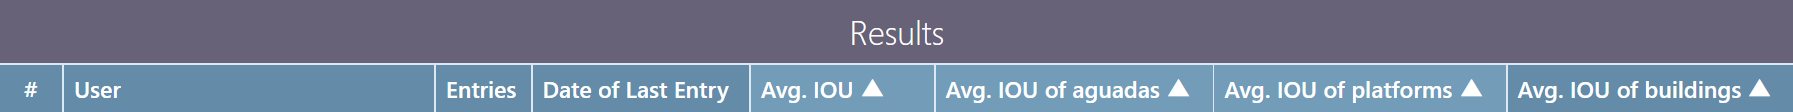

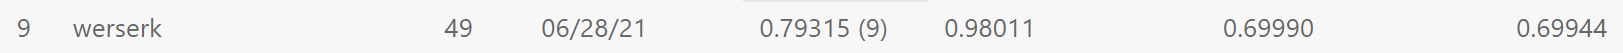

Все графики тут: https://wandb.ai/werserk121/MayaChallenge/reports/Maya-Challenge--Vmlldzo4MDYxMDA?accessToken=1z618f7q0s71h78cpx6918c2g1dc2tmk6xhoek9gldo010xatstk2rh9stnutabb

Сводка по названиям конфигураций:

DLV3 - DeepLabV3

RN*X* - ResNet*X*

ch*X* - каналов на входе *X*



---


* **Лучше всех себя показал себя ансамбль из 3-х моделей: DLV3_RN50_BCE_6ch для aguada, DLV3_RN50_IoU_6ch для building, DLV3_RN50_IoU_6ch для platform**
Эпохи: 12, 14, 15 соответственно

---


* В точности победила DLV3_RN101

Однако в сравнении с близкой по точности DLV3_RN50 у неё очень высокая длительность обучения (об ансамбле я подумал слишком поздно и не успел натренировать на RN101)


---


* В функциях потерь победила BCE на aguada и IoU на building и platform


---


* В каналах победила 6-и канальная конфигурация

Видимо 3-х каналов не хватает, а в 8-и модели начинают путаться и терять зависимости и выйгрыш от пре-тренировки


---

Идея об ансамбле появилась в предпоследний день сдачи и по факту я просто объединил все сильные стороны прошлых конфигураций различных моделей
